<a href="https://colab.research.google.com/github/xiayunj/2020_capstone_Unilever/blob/main/base_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import shutil
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np

In [2]:
# connect to your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 24
SHUFFLE_SIZE = 100

In [4]:
#Create image tf dataset from directory 
AUTOTUNE = tf.data.experimental.AUTOTUNE

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [512, 512])
  return image


all_image_paths = sorted(glob.glob("/content/drive/My Drive/Unilever/image_test/*.jpg"))
#path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
#image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
#DATASET_SIZE = len(image_ds)

In [5]:
# read the excel file
MHPgrades = pd.read_excel("/content/drive/My Drive/Unilever/MHPgrades.xlsx")
grade = MHPgrades["Mottled hyperpigmentation"]

all_image_labels = list(grade)
#label_names = list(sorted(grade.unique()))
#label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.float32))

In [6]:
all_label = []
for grade in all_image_labels:
  if grade < 2.0:
    label = 1.5
  elif grade > 4.0:
    label = 4.5
  else:
    label = grade
  all_label.append(label)

In [7]:
label_to_index = dict((name, index) for index, name in enumerate(sorted(set(all_label))))
label_to_index

{1.5: 0, 2.0: 1, 2.5: 2, 3.0: 3, 3.5: 4, 4.0: 5, 4.5: 6}

In [8]:
all_labels = [label_to_index[grade]
                    for grade in all_label]

print("First 10 labels indices: ", all_labels[:10])

First 10 labels indices:  [2, 2, 1, 0, 0, 2, 1, 1, 0, 0]


In [9]:
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(all_image_paths, all_labels) 

In [10]:
path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
DATASET_SIZE = len(image_ds)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.float32))

In [11]:
for label in label_ds.take(10):
  print(label)

tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)


In [12]:
# a dataset that returns images and labels
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<ZipDataset shapes: ((512, 512, 3), ()), types: (tf.float32, tf.float32)>


In [13]:
#image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [15]:
for img, label in image_label_ds.take(2):
  print(img.shape, label.numpy())

(512, 512, 3) 0.0
(512, 512, 3) 6.0


using generator

In [25]:
IMG_SIZE = 512
resize_and_rescale = tf.keras.Sequential([
  #layers.experimental.preprocessing.Resizing(299, 299),
  layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1)
])
data_augmentation = tf.keras.Sequential([                                      
   layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")
#   layers.experimental.preprocessing.RandomRotation(0.2),
#   layers.experimental.preprocessing.RandomContrast(0.2),
#   layers.experimental.preprocessing.RandomWidth(0.2),
#   layers.experimental.preprocessing.RandomHeight(0.2)

 ])

In [13]:
# here's our final training dataset
train_ds = image_label_ds.cache()
train_ds = train_ds.shuffle(SHUFFLE_SIZE)

#train_ds = train_ds.repeat()
#train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x, training=True), y))
#train_ds = train_ds.map(lambda image, Label: (tf.image.random_flip_left_right(image),Label),num_parallel_calls=AUTOTUNE)
#train_ds = train_ds.map(lambda image, Label: (tf.image.random_saturation(image,5,10),label),num_parallel_calls=AUTOTUNE)
#train_ds = train_ds.map(lambda image, Label: (tf.image.random_contrast(image,5,10),label),num_parallel_calls=AUTOTUNE)


train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# let's make a test dataset as well
path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.float32))
image_label_ds_test = tf.data.Dataset.zip((image_ds, label_ds))
test_ds = image_label_ds_test.cache().batch(BATCH_SIZE)

In [21]:
# A benchmark utility to time how long it takes
# to iterate once over the entire dataset
import time
def time_one_epoch(ds):
  start = time.time()
  batches = 0
  for i,(images,labels) in enumerate(ds):
    batches += 1
    if i % 10 == 0:
      print('.', end='')
  print()
  end = time.time()
  duration = end-start
  print("Read {} batches".format(batches))
  print("{:0.2f} Batches/s".format(batches/duration))
  print("{:0.2f} Images/s".format(BATCH_SIZE*batches/duration))
  print("Total time: {}s".format(duration))
time_one_epoch(train_ds)

...
Read 28 batches
44.68 Batches/s
1072.21 Images/s
Total time: 0.6267437934875488s


In [ ]:
for img, label in train_ds.take(2):
  print(img.shape, label.shape) # notice it's returning batches of data now

(24, 512, 512, 3) (24,)
(24, 512, 512, 3) (24,)


### base model


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', 
                        input_shape=(512, 512, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(7, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_ds, validation_data=test_ds, epochs=5)

#### Transfer Learning

In [16]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(include_top = False, weights = 'imagenet', 
                         input_shape = (512, 512, 3))

#base_model.trainable = True  

for layer in base_model.layers[:100]:
  layer.trainable = False

In [17]:
# A hack to show you the output shape of the model
for image_batch, label_batch in train_ds.take(1):
   pass
  
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(24, 16, 16, 2048)


In [18]:
drop_out = tf.keras.layers.Dropout(.2, input_shape =(24, 16, 16,2048))
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(7, activation='softmax')

In [19]:
# build a new model reusing the pretrained base
model3 = tf.keras.Sequential([
  base_model,
  drop_out,
  global_average_layer,
  prediction_layer
])

In [68]:
model3.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 16, 16, 2048)      23587712  
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 2048)      0         
_________________________________________________________________
global_average_pooling2d_8 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 19,467,271
Non-trainable params: 4,134,784
_________________________________________________________________


In [20]:
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [21]:
#  no rescale  no augmentation ,trainable = true
history3 = model3.fit(train_ds,
      epochs=50,
      callbacks=[callback],
      validation_data = test_ds)

Epoch 1/50
28/28 [==============================] - 27s 953ms/step - loss: 2.0382 - accuracy: 0.2470 - val_loss: 71.5533 - val_accuracy: 0.2432
Epoch 2/50
28/28 [==============================] - 22s 774ms/step - loss: 1.5819 - accuracy: 0.3328 - val_loss: 306.3428 - val_accuracy: 0.1486
Epoch 3/50
28/28 [==============================] - 22s 799ms/step - loss: 1.3148 - accuracy: 0.4458 - val_loss: 17.5806 - val_accuracy: 0.2703
Epoch 4/50
28/28 [==============================] - 22s 773ms/step - loss: 1.2365 - accuracy: 0.4729 - val_loss: 4.3095 - val_accuracy: 0.3559
Epoch 5/50
28/28 [==============================] - 21s 763ms/step - loss: 1.0950 - accuracy: 0.5648 - val_loss: 3.9814 - val_accuracy: 0.2838
Epoch 6/50
28/28 [==============================] - 22s 772ms/step - loss: 0.8780 - accuracy: 0.6401 - val_loss: 6.9610 - val_accuracy: 0.1802
Epoch 7/50
28/28 [==============================] - 22s 780ms/step - loss: 0.7204 - accuracy: 0.7244 - val_loss: 3.4174 - val_accuracy: 0.

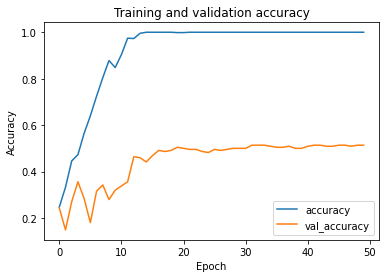

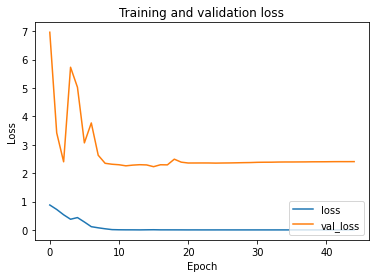

In [45]:
plot(history3)

In [47]:
def plot(history):
  
    plt.title('Training and validation accuracy')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()


    plt.figure()
    plt.title('Training and validation loss')
    plt.plot(history.history['loss'][7:], label='loss')
    plt.plot(history.history['val_loss'][7:], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')
    plt.show()

In [14]:
# build a new model reusing the pretrained base
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(include_top = False, weights = 'imagenet', 
                         input_shape = (512, 512, 3))


for layer in base_model.layers[:100]:
  layer.trainable = False

drop_out = tf.keras.layers.Dropout(.2, input_shape =(24, 16, 16,2048))
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(7, activation='softmax')


model2 = tf.keras.Sequential([
  base_model,
  drop_out,
  global_average_layer,
  prediction_layer
])


model2.compile(optimizer= "Adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


history2 = model2.fit(train_ds,
      epochs=50,
      callbacks = [callback],
      validation_data = test_ds)

94773248/94765736 [==============================] - 0s 0us/step
Epoch 1/50
28/28 [==============================] - 122s 4s/step - loss: 2.0088 - accuracy: 0.2440 - val_loss: 4647.3149 - val_accuracy: 0.1577
Epoch 2/50
28/28 [==============================] - 21s 756ms/step - loss: 1.5591 - accuracy: 0.3343 - val_loss: 1304.5890 - val_accuracy: 0.1577
Epoch 3/50
28/28 [==============================] - 20s 722ms/step - loss: 1.4570 - accuracy: 0.3855 - val_loss: 79.8538 - val_accuracy: 0.1216
Epoch 4/50
28/28 [==============================] - 20s 714ms/step - loss: 1.3272 - accuracy: 0.4563 - val_loss: 60.9877 - val_accuracy: 0.1982
Epoch 5/50
28/28 [==============================] - 20s 729ms/step - loss: 1.2280 - accuracy: 0.4789 - val_loss: 5.3737 - val_accuracy: 0.3063
Epoch 6/50
28/28 [==============================] - 21s 738ms/step - loss: 1.1293 - accuracy: 0.5437 - val_loss: 9.1930 - val_accuracy: 0.2252
Epoch 7/50
28/28 [==============================] - 20s 731ms/step - lo